In [186]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools

In [187]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [188]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

In [189]:
#word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

In [190]:
domain = ['apnea','obesity']
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
datapath='C:/Users/faisal/PycharmProjects/linkPrediction/dataframes'
modelpath='C:/Users/faisal/PycharmProjects/linkPrediction/models'
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[1990,1991,1996,1,1,20]
df, key_list = ut.load_dataset(filepath, column_split)

In [191]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
time=[1998,1999,2004,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

410
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle saved, nodes: 167 edges: 165
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000.gpickle saved, nodes: 179 edges: 293
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2001.gpickle saved, nodes: 203 edges: 300
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2002.gpickle saved, nodes: 200 edges: 288
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2003.gpickle saved, nodes: 233 edges: 312
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\test_graph_2004.gpickle saved, nodes: 410 edges: 628
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\parent_graph_1998-1999.gpickle saved, nodes: 135 edges: 168
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999-2004.gpickle saved, nodes: 410 edges: 1056
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\test_graph_2004-2005.gpickle saved, nodes: 410 edges: 628


In [192]:
#load all graphs
time=[2004,2005,2015,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2005.gpickle loaded, nodes: 70 edges: 47
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2006.gpickle loaded, nodes: 79 edges: 56
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2007.gpickle loaded, nodes: 400 edges: 699
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
C:/Users/faisal/Pycha

In [193]:
importlib.reload(fs)
importlib.reload(cl)

freq=10
#time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1310 neg in time series: 11132 pos-neg ratio: 0.11767876392382322 total: 12442


In [214]:
importlib.reload(fs)
importlib.reload(cl)

ts = time[1]
te = time[2]

row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
selective_features =  set(['y_weight1','pref','res_aloc','typeaut'])
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
models  = []
results = []
con = [4,64]
batch_size = con[1]
for feature in feature_list:
    columns_drop = list(set(feature_names).difference(set(feature)))
    if len(feature)==1 and feature[0] in selective_features:
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        model_file_name = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_name)
        models.append(model_name)
        print(model_file_name)

X shape: (12442, 10, 1) y shape: (12442,)
3733/3733 [==============================] - 0s 23us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2005-2015-typeaut.h5
X shape: (12442, 10, 1) y shape: (12442,)
3733/3733 [==============================] - 0s 22us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2005-2015-y_weight1.h5
X shape: (12442, 10, 1) y shape: (12442,)
3733/3733 [==============================] - 0s 26us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2005-2015-res_aloc.h5
X shape: (12442, 10, 1) y shape: (12442,)
3733/3733 [==============================] - 0s 22us/step
C:/Users/faisal/PycharmProjects/linkPrediction/models\apnea2005-2015-pref.h5


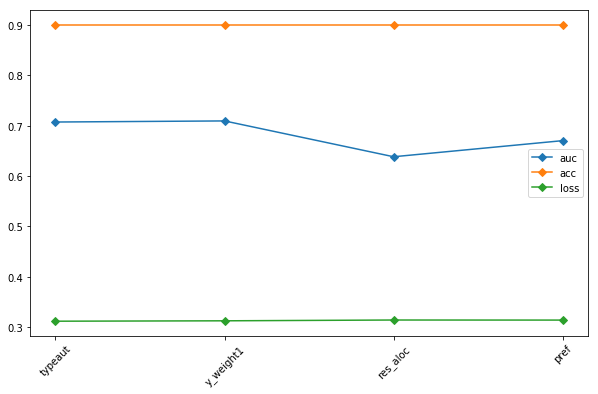

In [215]:
#result
model_names = []
loss = []
acc = []
auc = []
ff = set(['false positive','true positive'])
for row in results:
    for i,r in row.items():
        if i not in ff:
            #print(i,":",row[i])
            pass
    model_names.append(row['model name'].split('-')[2])
    loss.append(row['test score'])
    acc.append(row['test accuracy'])
    auc.append(row['auc'])
    #print()
    
#plot result
plt_for = [auc,acc,loss]
plt_for_name = ['auc','acc','loss']
plt.figure(figsize=(10,6))
for i,name in enumerate(plt_for):
    #plt.title(plt_for_name[i])
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.plot(name, '-D',label = plt_for_name[i])
plt.legend(loc='best')
no=1
fig_name = domain_info+'total feature'+str(no)+'-'+'freq-'+str(freq)+'parent-'+str(time[5])
fig_file_name = os.path.join(datapath, fig_name + ".png")
plt.savefig(fig_file_name)
plt.show()

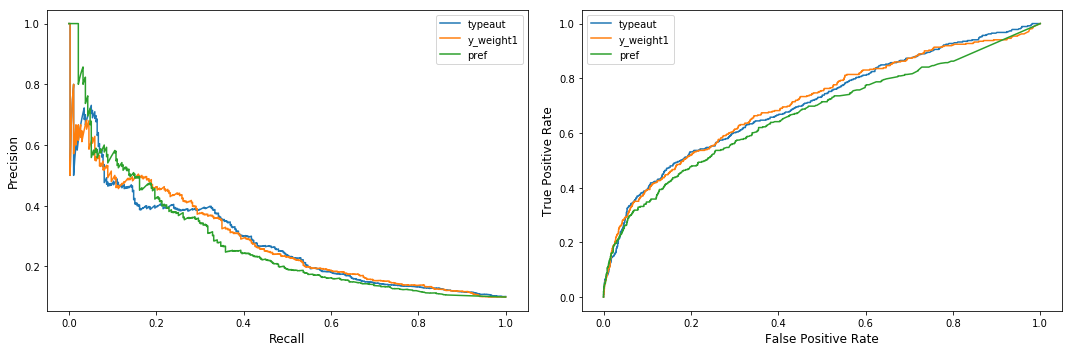

In [241]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i,row in enumerate(results):
    if i!=2:
        plt.plot(row['recall'],row['precision'],label = row['model name'].split('-')[2])
plt.legend(loc='best')
#plt.title("", position=(0.3, 0.8),fontsize=12)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.subplot(1,2,2)
for i,row in enumerate(results):
    if i!=2:
        plt.plot(row['false positive'],row['true positive'],label = row['model name'].split('-')[2])
plt.legend(loc='best')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.tight_layout()
fig_name = "PR and ROC curve"
fig_file_name = os.path.join(datapath, fig_name + ".png")
plt.savefig(fig_file_name)
plt.show()

In [282]:
#specific feature set classification
importlib.reload(fs)
importlib.reload(cl)
freq=10
time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1308 neg in time series: 11283 pos-neg ratio: 0.11592661526189843 total: 12591
dist_aut_art: 7.281818958612345 dist_y_weight: 10.049510090607624


In [385]:
# t=2013
# # train_data[t].loc[train_data[t]['label']==1,['y_weight1','pref']]
# node_feature[t]['term_aut']=ut.min_max_norm(node_feature[t]['term_aut'])
# node_feature[t]['term_coun']=ut.min_max_norm(node_feature[t]['term_coun'])
# node_feature[t].plot(y=['term_aut','term_coun'],figsize=(20,4))
train_data[2012].head()
col_list = ['aut','art','y_weight','typenode']

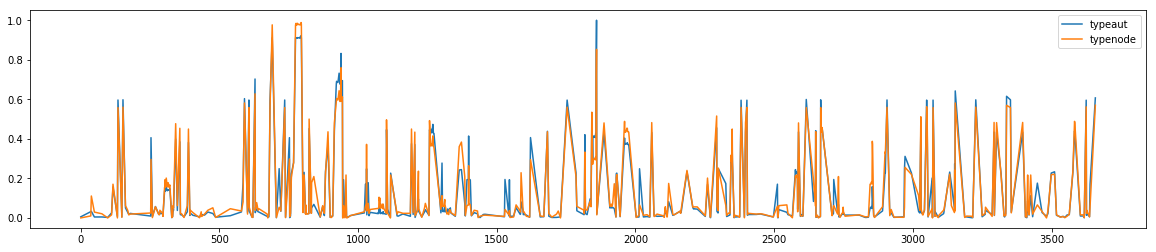

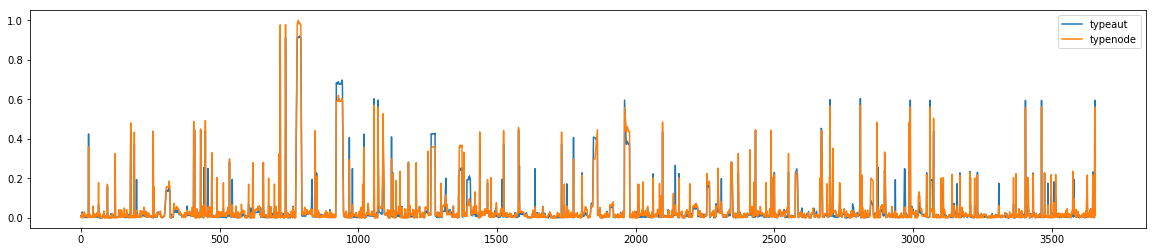

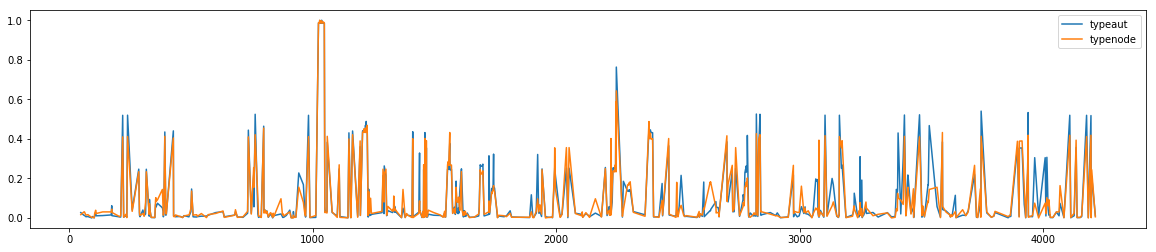

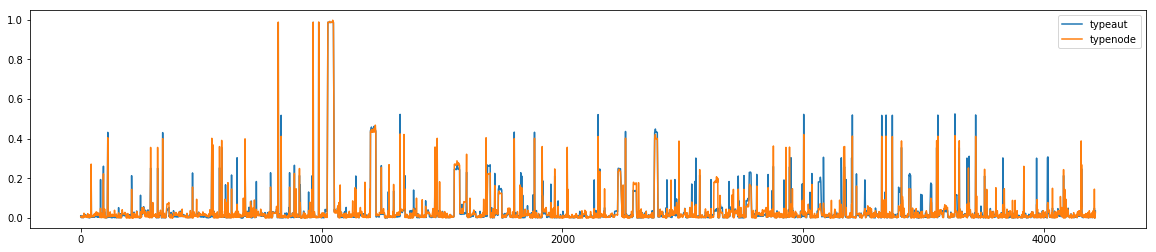

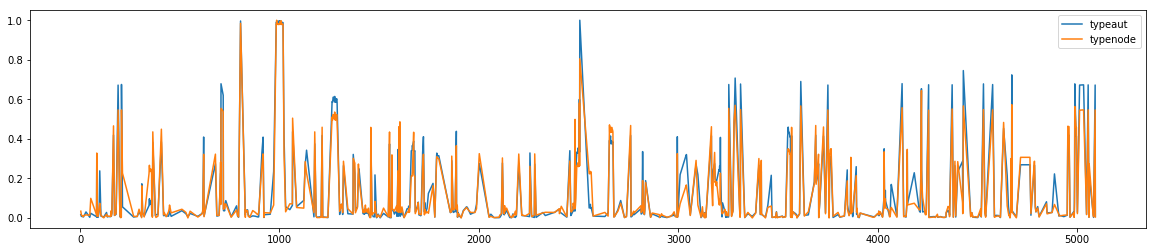

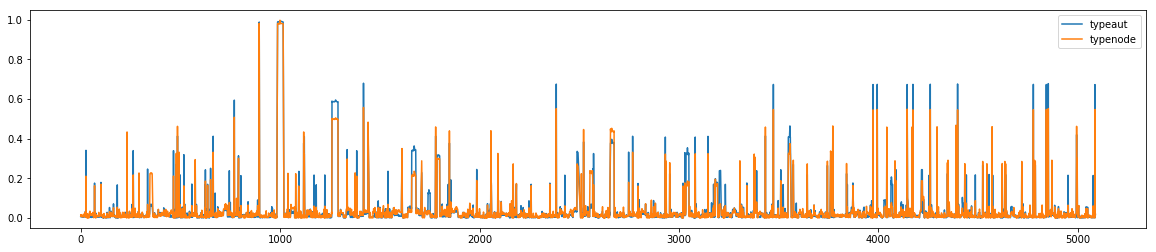

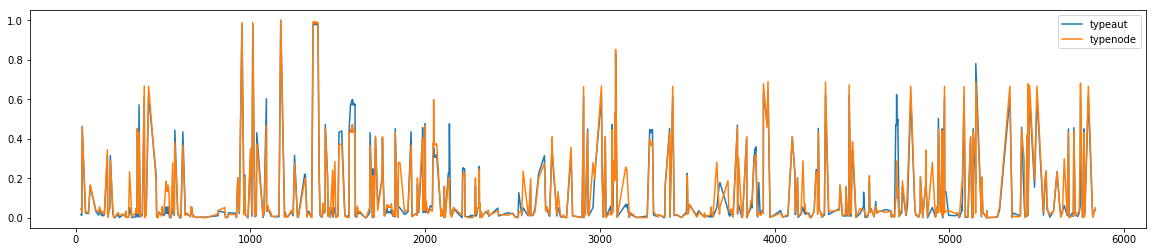

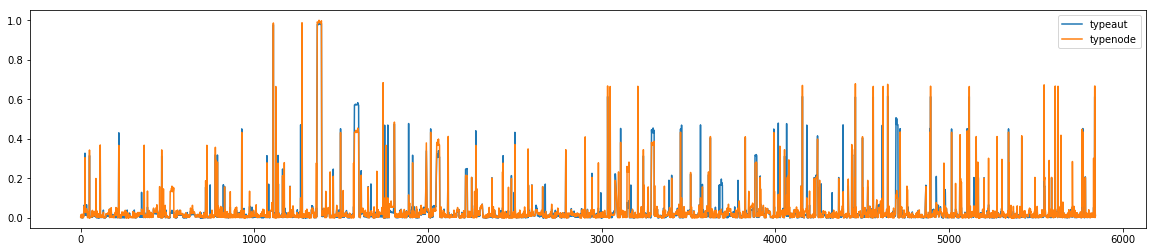

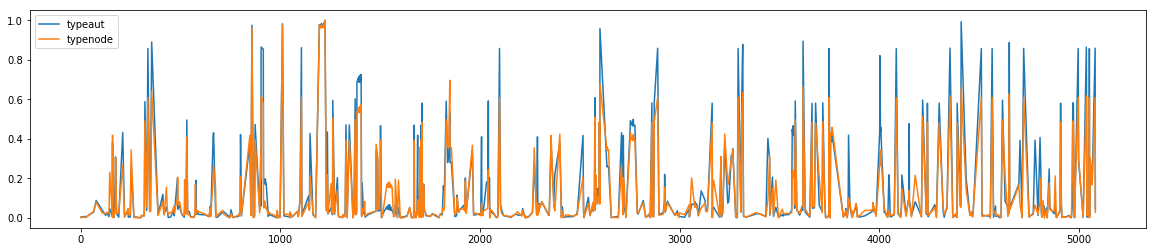

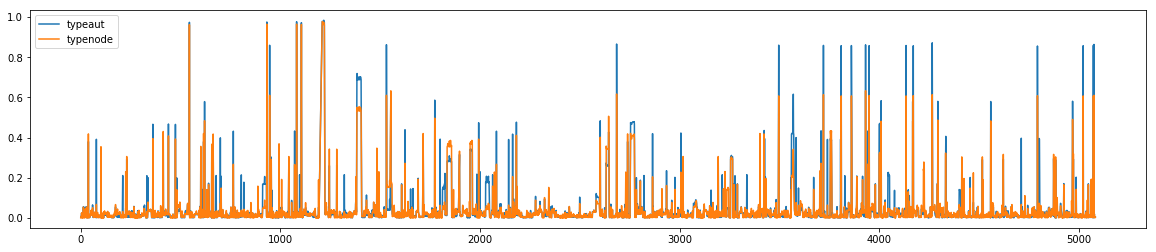

In [452]:
ts = time[1]
te = time[2]
for t in range(ts,te,1):
    train_data[t].loc[train_data[t]['label']==1,['typeaut','typenode']][['typeaut','typenode']].plot(figsize=(20,4))
    train_data[t].loc[train_data[t]['label']==0,['typeaut','typenode']][['typeaut','typenode']].plot(figsize=(20,4))

In [286]:
ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
con = [2,64]
batch_size = con[1]
#feature define
feature = ['y_weight1']
model_name = '+'.join(feature)
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
model_name = domain_info+model_name
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

X shape: (12591, 8, 1) y shape: (12591,)


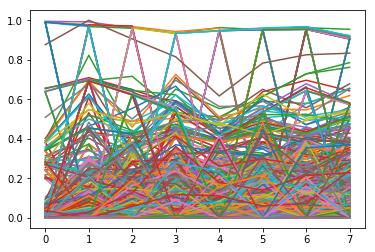

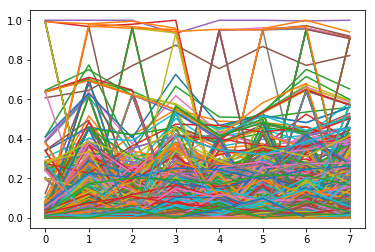

In [289]:
p=[]
n=[]
a=np.zeros(len(X))
for i,j in enumerate(X):
    a[i] = j.sum()
    if y[i]==1:
        #p.append(j.sum())
        #print(j.sum())
        plt.plot(j)
plt.show()
for i,j in enumerate(X):
    if y[i]==0:
        #n.append(j.sum())
        plt.plot(j)
plt.show()
# plt.figure(figsize=(20,4))
# plt.plot(p)
# plt.show()
# plt.plot(n)
# plt.show()
# plt.figure(figsize=(20,4))
# a = np.interp(a, (a.min(), a.max()), (0, +1))
# t1=2500
# t2=t1+500
# plt.plot(a[t1:t2])
# plt.plot(y[t1:t2])

# plt.show()

In [388]:
ts = time[1]
te = time[2]
row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
con = [20,64]
batch_size = con[1]
#feature define
feature = ['e']
model_name = '+'.join(feature)
domain_info =  domain[0]+str(ts)+"-"+str(te)+"-"
model_name = domain_info+model_name
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(train_data)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)

#train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
result = cl.model_evaluate(model, X_test, y_test, batch_size, model_name)

#evaluation result
not_show = set(['false positive','true positive'])
for i,r in result.items():
    if i not in not_show:
        print(i,":",result[i])

X shape: (12381, 5, 1) y shape: (12381,)
6191/6191 [==============================] - 0s 20us/step
model name : apnea2010-2015-e
test score : 0.3119197941821913
test accuracy : 0.8964626071642181
auc : 0.6556936655844613
